## **공통 라이브러리 및 드라이브 연동**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt 
import math
import cv2
impath = '/content/drive/My Drive/Colab Notebooks/Image_processing/image/lena_grey.bmp'

Mounted at /content/drive


## **1번 Design the edge detection system**

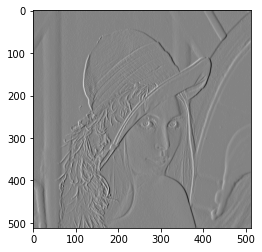

In [3]:
def sobel_gradient_dx(image):
    mx = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])   #sobel filter dx
    col, row = image.shape
    image = np.pad(image,1 ,'reflect')  #convolution을 위해 image padding
    dx = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            dx[i][j] = np.sum(image[i:i+3,j:j+3]*mx) #convolution
    return dx

image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image read
dx = sobel_gradient_dx(image)
plt.imshow(dx,cmap='gray')

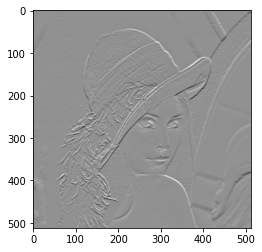

In [4]:
def sobel_gradient_dy(image):
    my = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]]) #sobel filter dy
    col, row = image.shape
    image = np.pad(image,1,'reflect')  #convolution을 위해 image padding
    dy = np.zeros((col,row))
    for i in range(col):
        for j in range(row):
            dy[i][j] = np.sum(image[i:i+3,j:j+3]*my)   #convolution
    return dy
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image read
dy = sobel_gradient_dy(image)
plt.imshow(dy,cmap='gray')

[[  0.           8.           0.         ...  64.         168.
    0.        ]
 [  0.           8.           0.         ...  64.         168.
    0.        ]
 [  0.           8.           0.         ...  64.         168.
    0.        ]
 ...
 [  8.          21.02379604  16.1245155  ...   4.24264069  24.08318916
   26.        ]
 [  4.          32.984845    25.61249695 ...  15.03329638  14.14213562
   24.        ]
 [  0.          36.          24.         ...  20.          12.
    0.        ]]


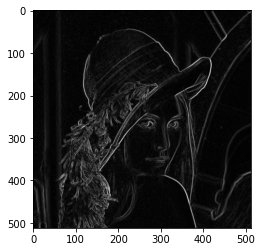

In [ ]:
def strength(dx,dy):
    mag = np.sqrt(dx**2+dy**2)   #구하는 식         
    return mag
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image read
dx,dy = sobel_gradient_dx(image),sobel_gradient_dy(image)
mag = strength(dx,dy)
plt.imshow(mag,cmap='gray')
print(mag)

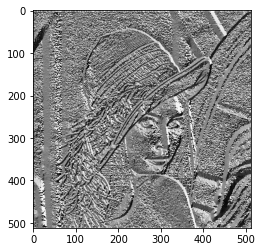

In [ ]:
def orientation(dx,dy):
    arc = np.arctan2(dy,dx) # arctan(dy/dx)
    return arc
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image read
dx,dy = sobel_gradient_dx(image),sobel_gradient_dy(image)
arc = orientation(dx,dy)
plt.imshow(arc,cmap='gray')

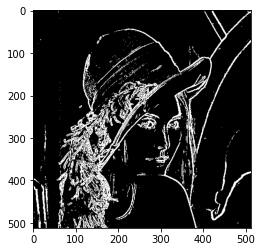

In [ ]:
def final_edge(magnitude,threshold):
    col, row = magnitude.shape
    final = np.zeros((col,row),dtype='uint8')
    for i in range(col):
        for j in range(row):
            if(magnitude[i][j]>threshold): #threshold값보다 크면 255
                final[i][j]=255
            else:                          #작으면 0
                final[i][j]=0
    return final
image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image read
dx,dy = sobel_gradient_dx(image),sobel_gradient_dy(image)
mag = strength(dx,dy)
final = final_edge(mag,100)
plt.imshow(final,cmap='gray')

## **2번 Canny edge detector**

[[  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


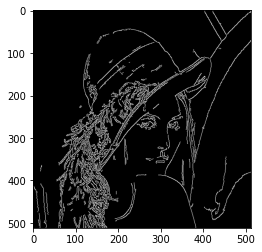

In [ ]:
a = cv2.Canny(image,100,200)
plt.imshow(a,cmap='gray')

## **3번 Design image scaling system**

[[143 143 143 ... 149   0   0]
 [143 143 144 ... 137   0   0]
 [143 143 144 ... 140   0   0]
 ...
 [ 38  38  45 ...  85   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


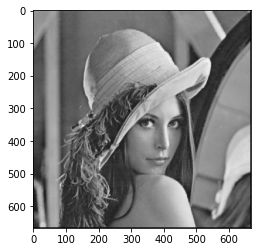

In [ ]:
def bilinear_scaling(image,k):
    col,row = image.shape
    col,row = round(col*k),round(row*k) #scale 된 image 크기
    scale_image = np.zeros((col,row))
    scale = np.array([[k,0,0],[0,k,0],[0,0,1]])
    scale_inverse = np.linalg.inv(scale) #scale 역행렬
    for i in range(col-2):
        for j in range(row-2):
            df = np.dot(scale_inverse,np.array([[i],[j],[1]]))
            df_i = np.trunc(df) #정수 부분
            df_f = df - df_i #소수 부분
            df_i = df_i.astype('uint16')
            x,y,b,a = df_i[0][0],df_i[1][0],df_f[0][0],df_f[1][0]
            scale_image[i][j] = ((1-a)*((1-b)*image[x][y]+b*image[x][y+1]))+(a*((1-b)*image[x+1][y]+b*image[x+1][y+1]))
    scale_image = scale_image.astype('uint8') #타입 변환
    return scale_image

image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
scale_image = bilinear_scaling(image,1.3)
print(scale_image)
plt.imshow(scale_image,cmap='gray')

## **4번 Design image transform system**

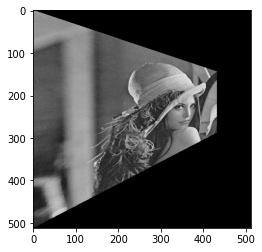

In [ ]:
def perspective(image,mat):
    col,row = image.shape
    trans = np.zeros((col,row))
    mat_inverse = np.linalg.inv(mat)
    for i in range(col):
        for j in range(row):
            df = np.dot(mat_inverse,np.array([[i],[j],[1]]))
            x,y = np.round(df[0][0]/df[2][0]),np.round(df[1][0]/df[2][0])
            x,y = x.astype('int32'), y.astype('int32')
            if x < 0 or x > 511 or y < 0 or y >511 :
                trans[j][i] = 0
            else:
                trans[j][i] = image[y][x]
    return trans

image = cv2.imread(impath, cv2.IMREAD_GRAYSCALE) #image 읽기
mat = [[3,0,0],[1,1,0],[0.005,0,1]]
trans = perspective(image,mat)
plt.imshow(trans,cmap='gray')